# TPS Sampling Tutorial

In this tutorial, you will set up and run a transition path sampling simulation for the $C_{7eq}$ to $\alpha_R$ transition in alanine dipeptide. This is similar to the work in [Bolhuis, Dellago, and Chandler. PNAS **97**, 5877 (2000)](http://dx.doi.org/10.1073/pnas.100127697).

You will learn aspects of three different tools:

* [`OpenMM`](http://openmm.org), which you will use to perform the actual MD
* [`MDTraj`](http://mdtraj.org), which you will use to select atoms from the topology (similar to making Gromacs `idx` files) and to calculate collective variables
* [`OpenPathSampling`](http://openpathsampling.org), which will manage the path sampling simulation

You will also use a few other useful libraries:

* [`openmmtools`](https://github.com/choderalab/openmmtools), a library of additions that are not included in the OpenMM core
* [`matplotlib`](http://matplotlib.org/), a library for creating plots

We start off by importing the libraries we'll need. It's common to keep all the imports at the top of the file:

In [50]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from openmm import app
import openmm as mm
import openmm.unit as unit
import openmmtools

import openpathsampling as paths
import openpathsampling.engines.openmm as ops_openmm

import mdtraj as md

## Setting up the engine

Path sampling methods wrap around molecular dynamics, so one of the first things you need to do when setting up a path sampling simulation is to set up a molecular dynamics engine. In this example, we'll use OpenMM as the underlying engine.

The next cell shows you how to set up several things specific to OpenMM. We'll be running in the $NVT$ ensemble, with $T=300 K$. We're using the [Velocity Verlet with Velocity Randomization (VVVR) integrator](http://arxiv.org/abs/1301.3800), which simulates Langevin dynamics. Note that the integrator itself comes from [`openmmtools`](https://github.com/choderalab/openmmtools), a library that extends OpenMM. You should always use a reversible integrator when performing path sampling simulations. The default integrators in OpenMM are leapfrog-based, and therefore not reversible.

You can learn a lot more about setting up OpenMM simulations from the [OpenMM documentation](http://docs.openmm.org/). However, it is often even easier to use [OpenMM-Setup](https://github.com/openmm/openmm-setup/) to learn how to set up the simulation the way you'd like.

In [51]:
# this cell is all OpenMM specific
forcefield = app.ForceField('amber96.xml', 'tip3p.xml')
system = forcefield.createSystem(
    topology=app.PDBFile("AD_initial_frame.pdb").topology,
    nonbondedMethod=app.PME,
    nonbondedCutoff=1.0*unit.nanometers,
    constraints=app.HBonds,
    rigidWater=True,
    ewaldErrorTolerance=0.0005
)

integrator = openmmtools.integrators.VVVRIntegrator(
    300*unit.kelvin,
    1.0/unit.picoseconds,
    2.0*unit.femtoseconds
)
integrator.setConstraintTolerance(0.00001)

Next we deal with the interface between OpenMM and OPS. We create an OPS `Engine` object that wraps around the OpenMM system and integrator you just created.

In [52]:
openmm_properties = {}
engine_options = {
    'n_frames_max': 2000,
    'n_steps_per_frame': 10
}
ops_topology = ops_openmm.tools.topology_from_pdb("AD_initial_frame.pdb")
engine = ops_openmm.Engine(
    topology=ops_topology,
    system=system,
    integrator=integrator,
    openmm_properties=openmm_properties,
    options=engine_options
)
engine.name = 'TPS MD Engine'

## Defining collective variables

We'll define our states based on the [Ramachandran angles](https://en.wikipedia.org/wiki/Ramachandran_plot) $\phi$ and $\psi$. These are dihedrals along the protein backbone, defined for residue $i$ as involving the following atoms:

* $\phi_i$: C$^{(i-1)}$, N$^{(i)}$, C$_\alpha^{(i)}$, C$^{(i)}$
* $\psi_i$: N$^{(i)}$, C$_\alpha^{(i)}$, C$^{(i)}$, N$^{(i+1)}$

where the parenthetical superscript indicates residue number. Note that the order of the atoms is important for the computation!

We'll need the atom numbers for these (just as Gromacs put those atom numbers into an `idx` file). To find them, we'll use MDTraj's `Topology` object. First, we convert the OPS `Topology` object to an MDTraj `Topology` object.

> NB: There are several types of `Topology` objects. See, for example, what you get from `type(engine.topology)` vs. `type(engine.simulation.topology)` and then `type(md_topology)` after you make it. The atom selection language discussed below is only for MDTraj topology objects.

In [53]:
md_topology = md.Topology.from_openmm(engine.simulation.topology)

MDTraj has an advanced [atom selection language](http://mdtraj.org/1.8.0/atom_selection.html). Here we'll print out the backbone atoms and their atom numbers, since we know the atoms for our collective variables are from the backbone.

In [54]:
for atom_number in md_topology.select("backbone"):
    print(atom_number, md_topology.atom(atom_number))

4 ACE1-C
5 ACE1-O
6 ALA2-N
8 ALA2-CA
14 ALA2-C
15 ALA2-O
16 NME3-N
18 NME3-C


There's only one pair of Ramachandran angles of interest here: the ones for residue 1, alanine. To figure out which atoms are needed, we use the definition of $\phi_i$, which tells us we need C$^{(0)}$, N$^{(1)}$, C$_\alpha^{(1)}$, and C$^{(1)}$; i.e., `ACE1-C`, `ALA2-N`, `ALA2-CA`, and `ALA2-C`. We can find the correct atom indices from the result of the previous cell.

In [55]:
# ACE1-C, ALA2-N, ALA2-CA, ALA2-C: 4,6,8,14
phi = paths.MDTrajFunctionCV("phi", md.compute_dihedrals, engine.topology, indices=[[4,6,8,14]])

In [67]:
# YOUR TURN: Define `psi`, similarly to `phi` above.
# Figure out which atoms make the dihedral, find their atom indices, then create the CV.
#dioporco
psi = paths.MDTrajFunctionCV("psi", md.compute_dihedrals, engine.topology, indices=[[6,8,14, 16]])

## Defining the stable states

Once we've created our collective variables, we use them to define our stable states. For this system, we'll define the stable states as follows:

* $C_{7\text{eq}}$: $-180 \le \phi \le 0$ and $100 \le \psi \le 200$
* $\alpha_R$: $-180 \le \phi \le 0$ and $-100 \le \psi \le 0$

with the angles measured in degrees.

Note that OPS allows you to intersect two volumes with `&`.

In [68]:
deg = 180.0/np.pi  # for conversion between radians and degrees

C_7eq = (
    paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg,
                                  period_min=-np.pi, period_max=np.pi)
    & paths.PeriodicCVDefinedVolume(psi, lambda_min=100/deg, lambda_max=200/deg,
                                    period_min=-np.pi, period_max=np.pi)
).named("C_7eq")

In [69]:
# YOUR TURN: define the `alpha_R` state
alpha_R = (
    paths.PeriodicCVDefinedVolume(phi, lambda_min=-180/deg, lambda_max=0/deg,
                                  period_min=-np.pi, period_max=np.pi)
    & paths.PeriodicCVDefinedVolume(psi, lambda_min=-100/deg, lambda_max=0/deg,
                                    period_min=-np.pi, period_max=np.pi)
).named("alpha_R")

You may have noticed that, even though the angles are defined from -180 degrees to 180 degrees, the C$_{7\text{eq}}$ state is defined $\psi$ up to 200 degrees. `PeriodicCVDefinedVolume` knows how to correctly handle volumes that wrap around a periodic boundary.

## Setting up the reaction network and move scheme

In OPS, path sampling simulations sample networks of reactions (even if the network only involves a simple $A\to B$ transition, as is the case here). For (flexible length) transition path sampling, use the `TPSNetwork` object.

OPS also allows you to set up many different kinds of move schemes. In flexible length transition path sampling, there's usually only one mover in the move scheme: a shooting mover. The `OneWayShootingMoveScheme` sets that up quickly. We will use uniform shooting point selection.

In [59]:
network = paths.TPSNetwork(initial_states=C_7eq, final_states=alpha_R)
scheme = paths.OneWayShootingMoveScheme(network=network,
                                        selector=paths.UniformSelector(),
                                        engine=engine).named("tps_scheme")

## Getting an initial trajectory

In practice, getting the initial trajectory can be one of the hardest parts of path sampling. For this example, you could easily do it by running high temperature MD to get an unphysical path, and then equilibrate it for a while. However, for the purposes of this tutorial, I already did that for you. So we'll just load the equilibrated trajectory from a file.

Note that this trajectory comes from an OPS NetCDF file. This should not be confused with the Amber NetCDF trajectory format. NetCDF is a storage backend that can handle arbitrary data. The way that data is organized for OPS is different from the way it is organized in Amber, so the file formats are not compatible.

In [60]:
init_traj_storage = paths.Storage("initial_trajectory.nc", 'r')
init_traj = init_traj_storage.trajectories[0]

The CVs you created act like functions when applied to a snapshot or trajectory. This allows us to easily plot the trajectory in $\phi$ and $\psi$, using `matplotlib`.

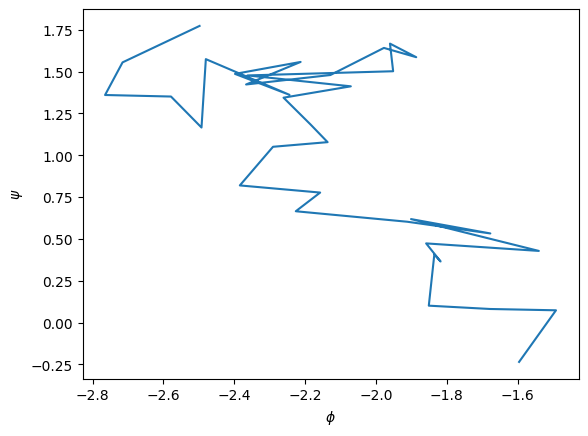

In [61]:
plt.plot(phi(init_traj), psi(init_traj))
plt.xlabel("$\phi$")
plt.ylabel("$\psi$");

The next step associates the initial trajectory with the ensemble we'll be sampling. This becomes important when there are multiple ensembles, as with transition interface sampling, and you must ensure that the initial trajectories are correct for each ensemble.

In [62]:
initial_conditions = scheme.initial_conditions_from_trajectories(init_traj)

No missing ensembles.
No extra ensembles.


This should tell you that there are no missing ensembles and no extra ensembles. If not, then there's a problem with your definition of the $\alpha_R$ state or with your definition of the $\psi$ collective variable. Check those very carefully.

## Running the simulation

Now all the parts are in place, and we can run the simulation! First, we open a file to store everything in, and then we build the simulation and run it.

In practice, for a long-running simulation you might save all the relevant information to a "setup" file, and then use the OPS Command Line Interface (CLI) to run it (perhaps on a remote computer). The advantage of that approach is that you can re-use the same exact objects, guaranteeing that they will behave the same way and making analysis easier. That approach is described in notebook 5 of this tutorial. In this notebook, we'll directly run the simulation.

In [63]:
storage = paths.Storage("tps_simulation_results.nc", "w", template=init_traj[0])

If you get a `PermissionError` when doing that, it probably means that you have already opened this file for writing. Use `storage.close()` to close the old file.

In [64]:
sampler = paths.PathSampling(storage=storage,
                             move_scheme=scheme,
                             sample_set=initial_conditions)

In [65]:
sampler.run(40)

Working on Monte Carlo cycle number 40
Running for 1 minute 1 second -  1.57 seconds per step
Estimated time remaining: 1 second
DONE! Completed 40 Monte Carlo cycles.


In [66]:
storage.close()

You're done running the (short) simulation. In the next notebook, we'll analyze these results, and then do a more thorough analysis of a longer simulation.
